# Pratical 1: indexing the data

In [ ]:
#Creating a function that produce the sparse matrix
import csv
def map_index_to_user_and_to_movie(path_file):
  map_user_to_idx={} #associating the id to index.
  data_index_to_user=[] #associating the index to id.
  map_movie_to_idx={}
  data_index_to_movie=[]
  map_idx_to_movie = []
  map_idx_to_user = []
  with open (path_file,'r') as f:
    reader=csv.reader(f)
    for row in reader: #visiting each row of the data
      user=row[0]
      movie=row[1]
      rating=row[2]
      if user != 'userId': #forgeting the first line
        if user not in map_user_to_idx: #adding the new user in the dictionary
          map_user_to_idx[user]=len(map_user_to_idx)
          map_idx_to_user.append(user)
          data_index_to_user.append([])
        if movie not in map_movie_to_idx: #adding the new movie in the dictionary
          map_movie_to_idx[movie]=len(map_movie_to_idx)
          data_index_to_movie.append([])
          map_idx_to_movie.append(movie)
        data_index_to_user[map_user_to_idx[user]].append((map_movie_to_idx[movie],float(rating)))
        data_index_to_movie[map_movie_to_idx[movie]].append((map_user_to_idx[user],float(rating)))
  return data_index_to_user,data_index_to_movie, map_user_to_idx, map_movie_to_idx, map_idx_to_user, map_idx_to_movie


In [ ]:
#Calling the function and stock each tools
data_idx_user, data_idx_movie, map_user_to_idx, map_movie_to_idx, map_idx_to_user, map_idx_to_movie = map_index_to_user_and_to_movie('ml-32m/ratings.csv')

In [ ]:
#Creating a dictionary that map each possible degree with its frequency(for data movie)
degree_movie_frequency={}
for i in range(len(data_idx_movie)):
  if len(data_idx_movie[i]) not in degree_movie_frequency:
    degree_movie_frequency[len(data_idx_movie[i])]=1
  else:
    degree_movie_frequency[len(data_idx_movie[i])]+=1
#Creating a dictionary as the same task for the users
degree_user_frequency={}
for i in range(len(data_idx_user)):
  if len(data_idx_user[i]) not in degree_user_frequency:
    degree_user_frequency[len(data_idx_user[i])]=1
  else:
    degree_user_frequency[len(data_idx_user[i])]+=1

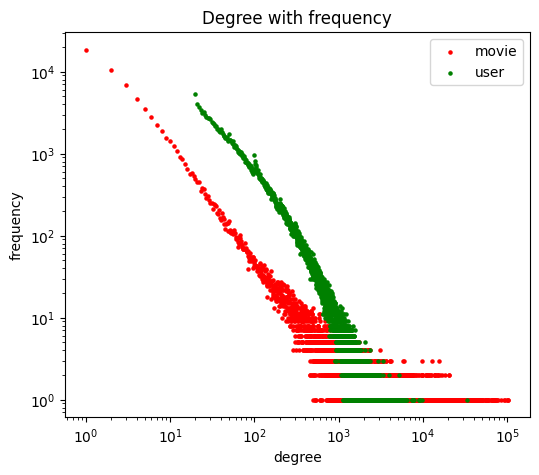

In [ ]:
#Using the dictionary to create the plot of the power laws.
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(6,5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(degree_movie_frequency.keys(),degree_movie_frequency.values(),marker='o', s=5, c='r', label='movie')
ax.scatter(degree_user_frequency.keys(),degree_user_frequency.values(),marker='o', s=5, c='g',  label='user')
ax.set_xlabel('degree')
ax.set_ylabel('frequency')
plt.legend()
ax.set_title('Degree with frequency')
plt.savefig('ratings.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
#Creating a dictionary that associate each possible value of ratings with its frequency.
ratings_frequency={}
for i in range(len(data_idx_user)):
  for j in range(len(data_idx_user[i])):
    if float(data_idx_user[i][j][1]) not in ratings_frequency:
      ratings_frequency[data_idx_user[i][j][1]]=1
    else:
      ratings_frequency[data_idx_user[i][j][1]]+=1

C:\Users\USER\AppData\Local\Temp\ipykernel_5980\3270401591.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


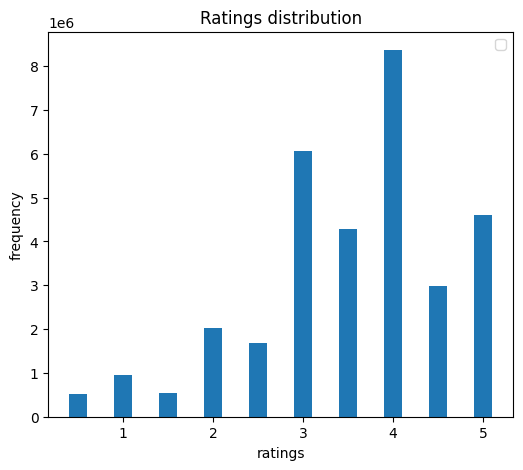

In [ ]:
#Using the dictionary above to generate the histogram associating the ratings with its frequency
fig,ax=plt.subplots(figsize=(6,5))
ax.bar(ratings_frequency.keys(),ratings_frequency.values(),width=0.2)
ax.set_xlabel('ratings')
ax.set_ylabel('frequency')
plt.legend()
ax.set_title('Ratings distribution')
plt.savefig('power.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Pratical 2: Biases only.

In [ ]:
#Function that split the dataset
import numpy as np
def split_data(data,a=0.2):
  train_data=[]
  test_data=[]
  for i in range(len(data)):
    train_dat=[]
    test_dat=[]
    for j in range(len(data[i])):
      if np.random.rand()<a: #equivalent to a flipping a coin but an advantage for the train.
        test_dat.append(data[i][j])
      else:
        train_dat.append(data[i][j])
    train_data.append(train_dat)
    test_data.append(test_dat)
  return train_data,test_data

In [ ]:
(data_by_user,data_by_movie)=map_index_to_user_and_to_movie('ratings.csv')
(train_data_user,test_data_user)=split_data(data_by_user,0.1)
(train_data_movie,test_data_movie)=split_data(data_by_movie,0.1)

In [ ]:
#Alternating least squares using the biases only.
user_biases=np.zeros(len(data_by_user)) #initialize the biases
item_biases=np.zeros(len(data_by_movie))
#initialize the hyper-parameters
lamda = 0.1
gamma = 0.02
#Creating the lists to stock all the loss and the RMSE
liste_lost = []
liste_rmse=[]
test_rmse = []
test_loss = []
epoch = 50
for j in range(epoch):
  #Updating the biases for the user vectors
  for i in range(len(data_by_user)):
    bias = 0
    item_counter = 0
    for (n,r) in data_by_user[i]:
      bias += lamda* (r - item_biases[n])
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    user_biases[i] = bias

  #updating the biases for the movie vectors
  for i in range(len(data_by_movie)):
    bias = 0
    item_counter = 0
    for (n,r) in data_by_movie[i]:
      bias += lamda* (r - user_biases[n])
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    item_biases[i]= bias

  #Calculating the RMSE for the data train
  rmse = 0
  a = 0
  for i in range(len(data_by_user)):
    a += len(data_by_user[i])
    for (n,r) in (train_data_user[i]):
      rmse += (r - (user_biases[i]+ item_biases[n]))**2
  rmse = np.sqrt((1/a)*(rmse))
  liste_rmse.append(rmse)

  #Calculating the RMSE for the data test.
  rmse_test = 0
  a = 0
  for i in range(len(test_data_user)):
    a += len(test_data_user[i])
    for (n,r) in (test_data_user[i]):
      rmse_test += (r - (user_biases[i]+ item_biases[n]))**2
  rmse_test = np.sqrt((1/a)*(rmse_test))
  test_rmse.append(rmse_test)

  #Calculating the loss for the data train
  loss = 0
  for i in range (len(train_data_user)):
    for (n,r) in (train_data_user[i]):
      loss += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(user_biases[i])**2 - (gamma / 2)*(item_biases[i])**2
  liste_lost.append(loss)

  #Calculating the loss for the data test.
  loss_test = 0
  for i in range(len(test_data_user)):
    for (n,r) in test_data_user[i]:
      loss_test += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(user_biases[i])**2 - (gamma / 2)*(item_biases[i])**2
  test_loss.append(loss_test)

  if j < 10 or (j>10 and j % 10==0):
    #printing the values of the RMSE and the loss in each epochs.
    print(f"loss:{loss},rmse train:{rmse}, loss test: {loss_test}, rmse test: {rmse_test}")



loss:-14423.230110632629,rmse train:0.7640936661443531, loss test: -1588.6630243405646, rmse test: 0.7993877074808685
loss:-14271.653542124997,rmse train:0.7483294240504663, loss test: -1572.419893373706, rmse test: 0.7828533892788159
loss:-14229.50863844425,rmse train:0.7471599961230593, loss test: -1567.900932534078, rmse test: 0.7815525417271866
loss:-14188.474379921372,rmse train:0.7470150192583997, loss test: -1563.4197555168178, rmse test: 0.7813786664415588
loss:-14146.642548137772,rmse train:0.7469836188792074, loss test: -1558.8145338670624, rmse test: 0.7813435792235983
loss:-14105.06591837057,rmse train:0.7469734794460446, loss test: -1554.2193451316498, rmse test: 0.7813343679552515
loss:-14064.170451919937,rmse train:0.7469692278360899, loss test: -1549.6902708683288, rmse test: 0.7813307669729049
loss:-14024.093719043583,rmse train:0.7469670160937107, loss test: -1545.2472773323607, rmse test: 0.7813283250372571
loss:-13984.872134298652,rmse train:0.7469656300733793, loss

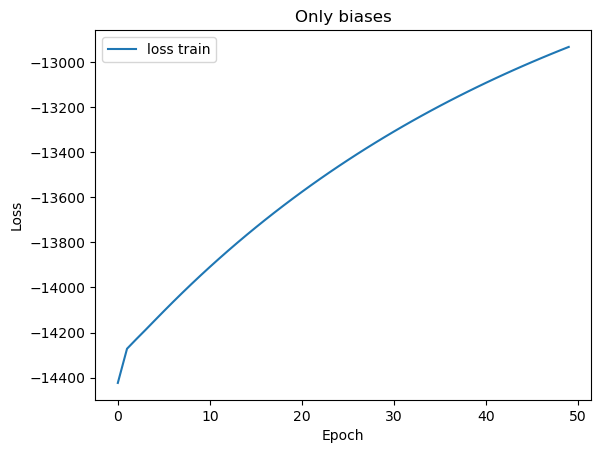

In [ ]:
#Plotting the loss for the train.
import matplotlib.pyplot as plt
plt.plot(liste_lost,label='loss train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Only biases')
plt.savefig('biases_loss.pdf', format='pdf', bbox_inches='tight')
plt.legend()

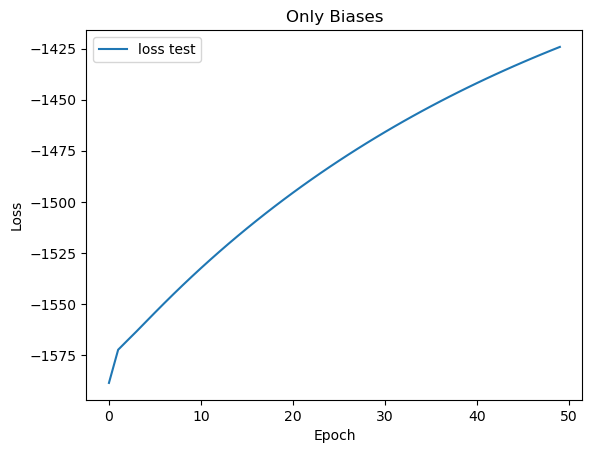

In [ ]:
#Plotting the loss test
import matplotlib.pyplot as plt
plt.plot(test_loss,label='loss test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Only Biases')
plt.savefig('biases_loss_test.pdf', format='pdf', bbox_inches='tight')
plt.legend()

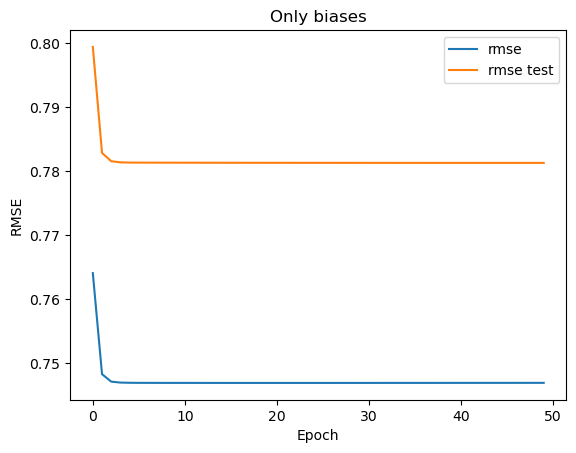

In [ ]:
#Plotting the RMSE for the train data and the test.
import matplotlib.pyplot as plt
plt.plot(liste_rmse,label='rmse')
plt.plot(test_rmse, label = 'rmse test')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Only biases')
plt.savefig('rmse_biases.pdf', format='pdf', bbox_inches='tight')
plt.legend()

# Practical 3

In [ ]:
#Alternating least squares using the biases and the embedding vectors.
k = 20
user_len = len(data_by_user)
mov_len = len(data_by_movie)

#Initialize the biases
user_biases=np.zeros(user_len)
item_biases=np.zeros(mov_len)

#Initialize the embedding vectors.
p=1/np.sqrt(k)
user_matrix = np.random.normal(0,p, (user_len,k))
movie_matrix = np.random.normal(0,p, (mov_len,k))
lamda = 0.02
gamma = 0.1
tau = 0.0002

#List stocking the losses and the RMSEs
liste_lost = []
liste_rmse=[]
test_rmse = []
test_loss = []
epoch = 50
for j in range(epoch):
  ##Updating the biases for the users
  for i in range(len(data_by_user)):
    user_vector = user_matrix[i,:]
    bias = 0
    item_counter = 0
    for (n,r) in data_by_user[i]:
      movie_vector = movie_matrix[n,:]
      bias += lamda* (r - item_biases[n] - np.dot(user_vector, movie_vector))
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    user_biases[i] = bias

  ##Updating the user vectors
  for i in range(len(data_by_user)):
    sum_vn = np.zeros((k,k))
    sum_r_vn = np.zeros(k)
    for (n,r) in data_by_user[i]:
      vn = movie_matrix[n,:]
      sum_vn += np.outer(vn,vn)
      sum_r_vn += lamda*(r - user_biases[i] - item_biases[n])*vn
    sum_vn = lamda*(sum_vn) + tau*np.eye(k)
    user_matrix[i,:] = np.linalg.solve(sum_vn, sum_r_vn)

  ##Updating the movie biases
  for n in range(len(data_by_movie)):
    movie_vector = movie_matrix[n,:]
    bias = 0
    item_counter = 0
    for (i,r) in data_by_movie[n]:
      user_vector = user_matrix[i,:]
      bias += lamda* (r - user_biases[i] - np.dot(user_vector, movie_vector))
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    item_biases[n]= bias

  ##Updating the movie vectors
  for n in range(len(data_by_movie)):
    sum_um = np.zeros((k,k))
    sum_r_um = np.zeros(k)
    for (m,r) in data_by_movie[n]:
      um = user_matrix[m,:]
      sum_um += np.outer(um,um)
      sum_r_um += lamda*(r - user_biases[m] - item_biases[n])*um
    sum_um = lamda*(sum_um) + tau*np.eye(k)
    movie_matrix[n,:] = np.linalg.solve(sum_um, sum_r_um)

  ##Calculating the RMSE for the train data
  rmse = 0
  a = 0
  for i in range(len(train_data_user)):
    a += len(train_data_user[i])
    user_vector = user_matrix[i,:]
    for (n,r) in (train_data_user[i]):
      movie_vector = movie_matrix[n,:]
      rmse += (r - (user_biases[i]+ item_biases[n]+np.dot(user_vector,movie_vector)))**2
  rmse = np.sqrt((1/a)*(rmse))
  liste_rmse.append(rmse)

  ##Calculating the RMSE for the test data.
  rmse_test = 0
  a = 0
  for i in range(len(test_data_user)):
    a += len(test_data_user[i])
    user_vector = user_matrix[i,:]
    for (n,r) in (test_data_user[i]):
      movie_vector = movie_matrix[n,:]
      rmse_test += (r - (user_biases[i]+ item_biases[n] + np.dot(movie_vector, user_vector)))**2
  rmse_test = np.sqrt((1/a)*(rmse_test))
  test_rmse.append(rmse_test)

  ##Calculating the loss for the train data
  loss = 0
  for i in range (len(train_data_user)):
    us_b = user_biases[i]
    user_vector = user_matrix[i,:]
    for (n,r) in (train_data_user[i]):
      mv_b = item_biases[n]
      movie_vector = movie_matrix[n,:]
      loss += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  liste_lost.append(loss)

  ##Calculating the loss for the test data.
  loss_test = 0
  for i in range(len(test_data_user)):
    us_b = user_biases[i]
    user_vector = user_matrix[i,:]
    for (n,r) in test_data_user[i]:
      movie_vector = movie_matrix[n,:]
      loss_test += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  test_loss.append(loss_test)

  if j < 10 or (j>10 and j % 10==0):
    #Printing the values in each epoch.
    print(f"loss:{loss},rmse train:{rmse}, loss test: {loss_test}, rmse test: {rmse_test}")



loss:-54570.05698111845,rmse train:0.4963338310948158, loss test: -6091.770928331013, rmse test: 0.49994580858481463
loss:-51678.57499506171,rmse train:0.4514970849858552, loss test: -5713.125589124037, rmse test: 0.45331330825072064
loss:-49274.4829168956,rmse train:0.4296472879517703, loss test: -5428.938961601812, rmse test: 0.4305268819379179
loss:-47243.587562951965,rmse train:0.41679266264498777, loss test: -5193.188725880664, rmse test: 0.417260035238501
loss:-45504.851858659495,rmse train:0.40807436778435413, loss test: -4991.456328656978, rmse test: 0.40807134642940357
loss:-43993.19954869855,rmse train:0.4015492064654279, loss test: -4815.468315230532, rmse test: 0.4010420208085183
loss:-42660.57321993553,rmse train:0.3963014518086322, loss test: -4659.797612669196, rmse test: 0.39567450441219465
loss:-41471.850064565246,rmse train:0.3918937765341904, loss test: -4520.596346606845, rmse test: 0.3913577822945299
loss:-40401.00058987856,rmse train:0.38812327158967014, loss test

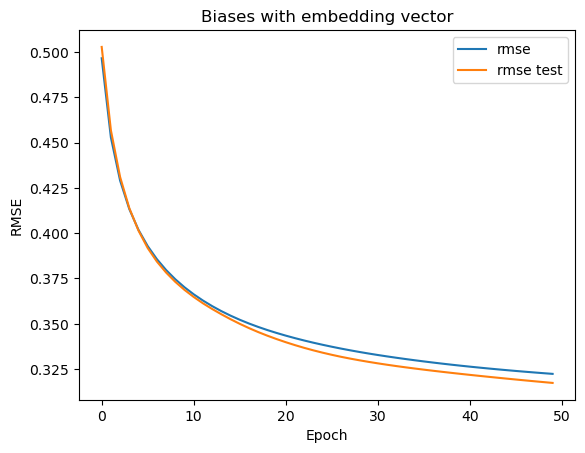

In [ ]:
#Plotting the RMSE
import matplotlib.pyplot as plt
plt.plot(liste_rmse,label='rmse')
plt.plot(test_rmse, label = 'rmse test')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Biases with embedding vector')
plt.savefig('rmse.pract3.pdf', format = 'pdf', bbox_inches = 'tight')
plt.legend()

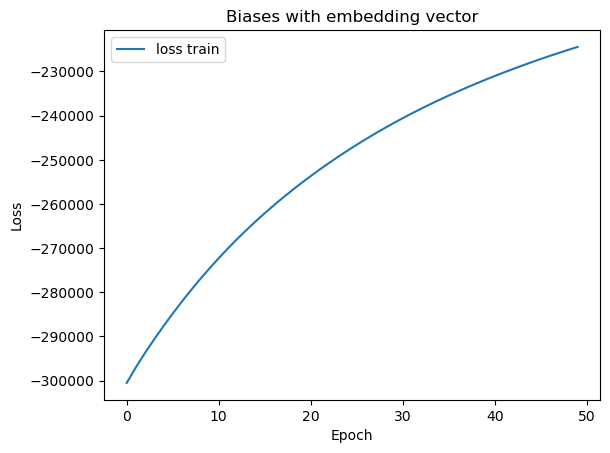

In [ ]:
#Plotting the loss for the train
import matplotlib.pyplot as plt
plt.plot(liste_lost,label='loss train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biases with embedding vector')
plt.savefig('loss.pract3.pdf', format = 'pdf', bbox_inches = 'tight')
plt.legend()

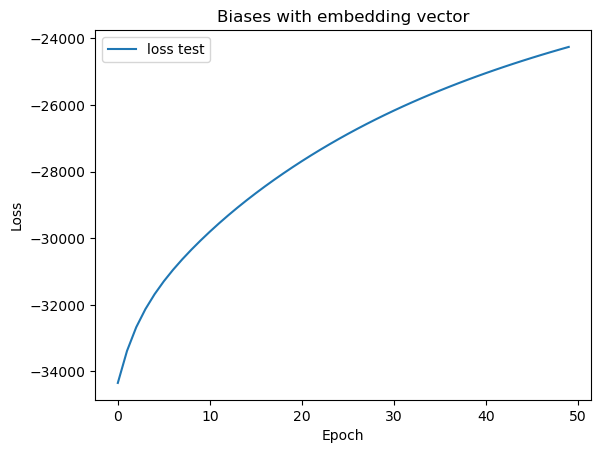

In [ ]:
#Plotting the loss for the test.
import matplotlib.pyplot as plt
plt.plot(test_loss,label='loss test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biases with embedding vector')
plt.savefig('loss_test.pract3.pdf', format = 'pdf', bbox_inches = 'tight')
plt.legend()

# Practical 4: Going big

In [ ]:
#creating the sparse matrix for the big data.
(data_by_user,data_by_movie,map_user_to_idx, map_movie_to_idx, map_idx_to_user, map_idx_to_movie)=map_index_to_user_and_to_movie('ml-32m/ratings.csv')
(train_data_user,test_data_user)=split_data(data_by_user,0.1)
(train_data_movie,test_data_movie)=split_data(data_by_movie,0.1)


In [ ]:
#Alternating least squares for the big data using only the train data for the update.
k = 10 #choosing the embedding dimension.
user_len = len(data_by_user)
mov_len = len(data_by_movie)

#Initialize the biases
user_biases=np.zeros(user_len)
item_biases=np.zeros(mov_len)

#initialize the embedding vectors.
p=1/np.sqrt(k)
user_matrix = np.random.normal(0,p, (user_len,k))
movie_matrix = np.random.normal(0,p, (mov_len,k))
lamda = 0.5
gamma = 0.5
tau = 0.002

#creating the lists stocking all the losses and the RMSE.
liste_lost = []
liste_rmse=[]
test_rmse = []
test_loss = []
epoch = 20
for j in range(epoch):

  #updating the biases for users
  for i in range(len(train_data_user)):
    user_vector = user_matrix[i,:]
    bias = 0
    item_counter = 0
    for (n,r) in train_data_user[i]:
      movie_vector = movie_matrix[n,:]
    user_biases[i] = bias

  #updating the vectors for the users
  for i in range(len(train_data_user)):
    sum_vn = np.zeros((k,k))
    sum_r_vn = np.zeros(k)
    for (n,r) in train_data_user[i]:
      vn = movie_matrix[n,:]
      sum_vn += np.einsum('i,j->ij',vn,vn)
      sum_r_vn += lamda*(r - user_biases[i] - item_biases[n])*vn
    sum_vn = lamda*(sum_vn) + tau*np.eye(k)
    user_matrix[i,:] = np.linalg.solve(sum_vn,sum_r_vn)

  #updating the biases for the movies
  for n in range(len(train_data_movie)):
    movie_vector = movie_matrix[n,:]
    bias = 0
    item_counter = 0
    for (i,r) in train_data_movie[n]:
      user_vector = user_matrix[i,:]
      bias += lamda* (r - user_biases[i] - np.dot(user_vector, movie_vector))
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    item_biases[n]= bias

  #updating the vectors for the movies
  for n in range(len(train_data_movie)):
    sum_um = np.zeros((k,k))
    sum_r_um = np.zeros(k)
    for (m,r) in train_data_movie[n]:
      um = user_matrix[m,:]
      sum_um += np.einsum('i,j->ij',um,um)
      sum_r_um += lamda*(r - user_biases[m] - item_biases[n])*um
    sum_um = lamda*(sum_um) + tau*np.eye(k)
    movie_matrix[n,:] = np.linalg.solve(sum_um, sum_r_um)

  #Calculating the RMSE for the train
  rmse = 0
  a = 0
  for i in range(len(train_data_user)):
    a += len(train_data_user[i])
    user_vector = user_matrix[i,:]
    for (n,r) in (train_data_user[i]):
      movie_vector = movie_matrix[n,:]
      rmse += (r - (user_biases[i]+ item_biases[n]+np.dot(user_vector,movie_vector)))**2
  rmse = np.sqrt((1/a)*(rmse))
  liste_rmse.append(rmse)

  #Calculating the RMSE for the test
  rmse_test = 0
  a = 0
  for i in range(len(test_data_user)):
    a += len(test_data_user[i])
    user_vector = user_matrix[i,:]
    for (n,r) in (test_data_user[i]):
      movie_vector = movie_matrix[n,:]
      rmse_test += (r - (user_biases[i]+ item_biases[n] + np.dot(movie_vector, user_vector)))**2
  rmse_test = np.sqrt((1/a)*(rmse_test))
  test_rmse.append(rmse_test)

  #Calculating the loss function the train.
  loss = 0
  for i in range (len(train_data_user)):
    us_b = user_biases[i]
    user_vector = user_matrix[i,:]
    for (n,r) in (train_data_user[i]):
      mv_b = item_biases[n]
      movie_vector = movie_matrix[n,:]
      loss += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  liste_lost.append(loss)

  #Calculating the loss function for the test.
  loss_test = 0
  for i in range(len(test_data_user)):
    us_b = user_biases[i]
    user_vector = user_matrix[i,:]
    for (n,r) in test_data_user[i]:
      movie_vector = movie_matrix[n,:]
      loss_test += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  test_loss.append(loss_test)

  if j < 10 or (j>10 and j % 10==0):
    print(f"loss:{loss},rmse train:{rmse}, loss test: {loss_test}, rmse test: {rmse_test}")



loss:-96974571.52448371,rmse train:0.8260841913225929, loss test: -10712515.320824603, rmse test: 0.8877351833041432
loss:-95607835.77989343,rmse train:0.7829533933140587, loss test: -10539498.025547013, rmse test: 0.8552340573021511
loss:-93847610.75904572,rmse train:0.7557939507060201, loss test: -10329552.389644273, rmse test: 0.8317520777829622
loss:-92218114.15803829,rmse train:0.7395421632560534, loss test: -10139390.301081609, rmse test: 0.8179346490027055
loss:-90885258.84930417,rmse train:0.7296015759637199, loss test: -9996062.226430604, rmse test: 0.809265027038305
loss:-89610581.13640812,rmse train:0.7231359378998042, loss test: -9842904.444904659, rmse test: 0.8040502865614497
loss:-88517144.16039963,rmse train:0.718912239630242, loss test: -9721586.864782197, rmse test: 0.8016316623235895
loss:-87510348.62515183,rmse train:0.7160047448213722, loss test: -9611033.445918076, rmse test: 0.8006283435469004
loss:-86551794.80998777,rmse train:0.7138813734086471, loss test: -950

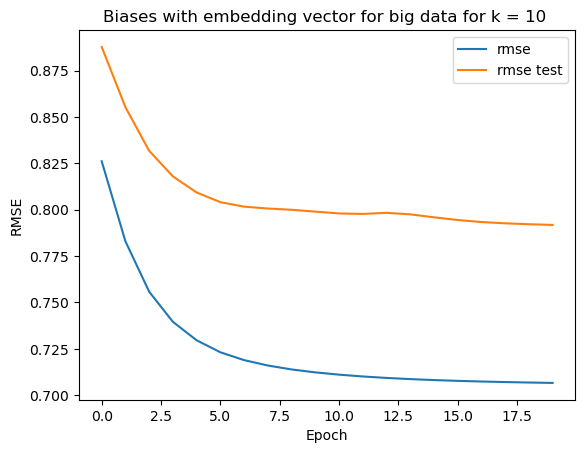

In [ ]:
#Plotting the RMSE for the train and test data
import matplotlib.pyplot as plt
plt.plot(liste_rmse,label='rmse')
plt.plot(test_rmse, label = 'rmse test')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Biases with embedding vector for big data for k = 10 ')
plt.savefig('rmse.pract4.10.pdf', format = 'pdf', bbox_inches = 'tight')
plt.legend()

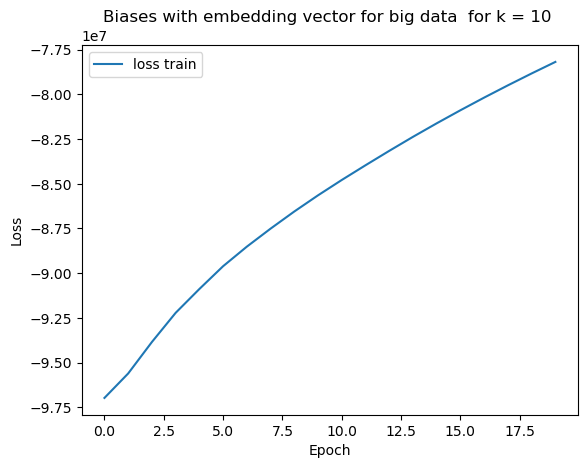

In [ ]:
#Plotting the loss for the train data.
import matplotlib.pyplot as plt
plt.plot(liste_lost,label='loss train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biases with embedding vector for big data  for k = 10 ')
plt.savefig('loss.10.pdf', format = 'pdf', bbox_inches = 'tight')
plt.legend()

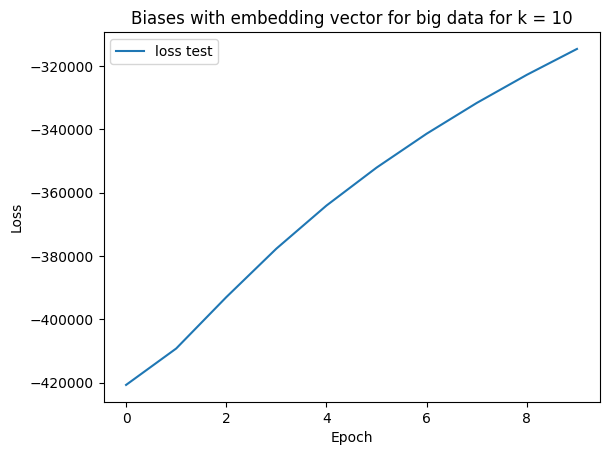

In [ ]:
#Plotting the loss for test data.
import matplotlib.pyplot as plt
plt.plot(test_loss,label='loss test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biases with embedding vector for big data for k = 10')
plt.legend()

In [ ]:
#The same training loop using k=20 for the embedding dimension.
k = 20
user_len = len(data_by_user)
mov_len = len(data_by_movie)
user_biases=np.zeros(user_len)
item_biases=np.zeros(mov_len)
p=1/np.sqrt(k)
user_matrix = np.random.normal(0,p, (user_len,k))
movie_matrix = np.random.normal(0,p, (mov_len,k))
lamda = 0.2
gamma = 0.01
tau = 0.002
liste_lost = []
liste_rmse=[]
test_rmse = []
test_loss = []
epoch = 20
for j in range(epoch):
  for i in range(len(train_data_user)):
    user_vector = user_matrix[i,:]
    bias = 0
    item_counter = 0
    for (n,r) in train_data_user[i]:
      movie_vector = movie_matrix[n,:]
      bias += lamda* (r - item_biases[n] - np.dot(user_vector, movie_vector))
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    user_biases[i] = bias

  for i in range(len(train_data_user)):
    sum_vn = np.zeros((k,k))
    sum_r_vn = np.zeros(k)
    for (n,r) in train_data_user[i]:
      vn = movie_matrix[n,:]
      sum_vn += np.einsum('i,j->ij',vn,vn)
      sum_r_vn += lamda*(r - user_biases[i] - item_biases[n])*vn
    sum_vn = lamda*(sum_vn) + tau*np.eye(k)
    user_matrix[i,:] = np.linalg.solve(sum_vn,sum_r_vn)


  for n in range(len(train_data_movie)):
    movie_vector = movie_matrix[n,:]
    bias = 0
    item_counter = 0
    for (i,r) in train_data_movie[n]:
      user_vector = user_matrix[i,:]
      bias += lamda* (r - user_biases[i] - np.dot(user_vector, movie_vector))
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    item_biases[n]= bias

  for n in range(len(train_data_movie)):
    sum_um = np.zeros((k,k))
    sum_r_um = np.zeros(k)
    for (m,r) in train_data_movie[n]:
      um = user_matrix[m,:]
      sum_um += np.einsum('i,j->ij',um,um)
      sum_r_um += lamda*(r - user_biases[m] - item_biases[n])*um
    sum_um = lamda*(sum_um) + tau*np.eye(k)
    movie_matrix[n,:] = np.linalg.solve(sum_um, sum_r_um)

  rmse = 0
  a = 0
  for i in range(len(train_data_user)):
    a += len(train_data_user[i])
    user_vector = user_matrix[i,:]
    for (n,r) in (train_data_user[i]):
      movie_vector = movie_matrix[n,:]
      rmse += (r - (user_biases[i]+ item_biases[n]+np.dot(user_vector,movie_vector)))**2
  rmse = np.sqrt((1/a)*(rmse))
  liste_rmse.append(rmse)

  rmse_test = 0
  a = 0
  for i in range(len(test_data_user)):
    a += len(test_data_user[i])
    user_vector = user_matrix[i,:]
    for (n,r) in (test_data_user[i]):
      movie_vector = movie_matrix[n,:]
      rmse_test += (r - (user_biases[i]+ item_biases[n] + np.dot(movie_vector, user_vector)))**2
  rmse_test = np.sqrt((1/a)*(rmse_test))
  test_rmse.append(rmse_test)

  loss = 0
  for i in range (len(train_data_user)):
    us_b = user_biases[i]
    user_vector = user_matrix[i,:]
    for (n,r) in (train_data_user[i]):
      mv_b = item_biases[n]
      movie_vector = movie_matrix[n,:]
      loss += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  liste_lost.append(loss)

  loss_test = 0
  for i in range(len(test_data_user)):
    us_b = user_biases[i]
    user_vector = user_matrix[i,:]
    for (n,r) in test_data_user[i]:
      movie_vector = movie_matrix[n,:]
      loss_test += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  test_loss.append(loss_test)

  if j < 10 or (j>10 and j % 10==0):
    print(f"loss:{loss},rmse train:{rmse}, loss test: {loss_test}, rmse test: {rmse_test}")



loss:-285017.61146220035,rmse train:0.7966894021670995, loss test: -31575.081184031824, rmse test: 0.8904642144500061
loss:-303897.8976363133,rmse train:0.7286169743960829, loss test: -33581.66050001256, rmse test: 0.8293444019652596
loss:-315657.1705717809,rmse train:0.6938610996656057, loss test: -34887.67568554899, rmse test: 0.7958693393904099
loss:-323055.44622768165,rmse train:0.6773232429444174, loss test: -35720.29218385059, rmse test: 0.7800950680021101
loss:-327916.6494895068,rmse train:0.6684530115277437, loss test: -36269.22931286274, rmse test: 0.7719570535850473
loss:-331347.19122953014,rmse train:0.6632209544438917, loss test: -36655.78241418293, rmse test: 0.7674323391906742
loss:-333964.263167958,rmse train:0.65984336630234, loss test: -36949.06684273482, rmse test: 0.7647402359234595
loss:-336099.83805718215,rmse train:0.6574976901691442, loss test: -37186.79429783729, rmse test: 0.7630392380345388
loss:-337925.4979969218,rmse train:0.65578214272444, loss test: -37388

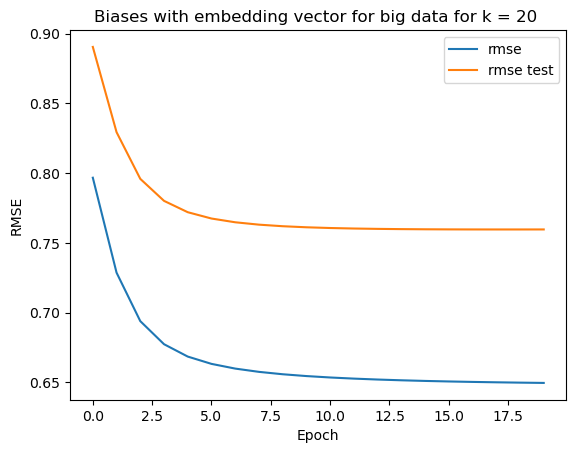

In [ ]:
#Plot of the RMSEs for k=20
import matplotlib.pyplot as plt
plt.plot(liste_rmse,label='rmse')
plt.plot(test_rmse, label = 'rmse test')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Biases with embedding vector for big data for k = 20 ')
plt.savefig('rmse.pract4.20.pdf', format = 'pdf', bbox_inches = 'tight')
plt.legend()

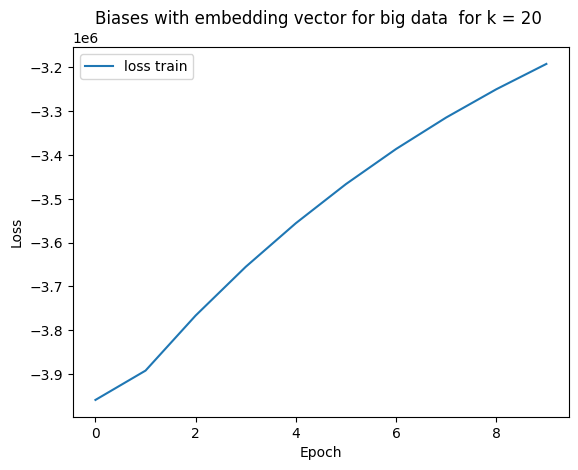

In [ ]:
#Plot of the loss for the data train.
import matplotlib.pyplot as plt
plt.plot(liste_lost,label='loss train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biases with embedding vector for big data  for k = 20 ')
plt.legend()

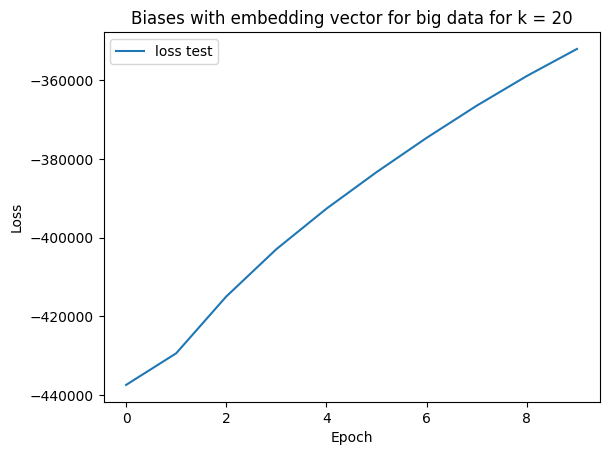

In [ ]:
#Plot of the loss for the data test.
import matplotlib.pyplot as plt
plt.plot(test_loss,label='loss test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biases with embedding vector for big data for k = 20')
plt.legend()

In [ ]:
#Final embeddings and biases with k=20 and different hyper-paramaters.
k = 20
user_len = len(data_by_user)
mov_len = len(data_by_movie)
user_biases=np.zeros(user_len)
item_biases=np.zeros(mov_len)
p=1/np.sqrt(k)
user_matrix = np.random.normal(0,p, (user_len,k))
movie_matrix = np.random.normal(0,p, (mov_len,k))
lamda = 0.2
gamma = 0.1
tau = 0.2
liste_lost = []
liste_rmse=[]
test_rmse = []
test_loss = []
epoch = 10
for j in range(epoch):
  for i in range(len(data_by_user)):
    user_vector = user_matrix[i,:]
    bias = 0
    item_counter = 0
    for (n,r) in data_by_user[i]:
      movie_vector = movie_matrix[n,:]
      bias += lamda* (r - item_biases[n] - np.dot(user_vector, movie_vector))
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    user_biases[i] = bias

  for i in range(len(data_by_user)):
    sum_vn = np.zeros((k,k))
    sum_r_vn = np.zeros(k)
    for (n,r) in data_by_user[i]:
      vn = movie_matrix[n,:]
      sum_vn += np.outer(vn,vn)
      sum_r_vn += lamda*(r - user_biases[i] - item_biases[n])*vn
    sum_vn = lamda*(sum_vn) + tau*np.eye(k)
    user_matrix[i,:] = np.linalg.solve(sum_vn, sum_r_vn)


  for n in range(len(data_by_movie)):
    movie_vector = movie_matrix[n,:]
    bias = 0
    item_counter = 0
    for (i,r) in data_by_movie[n]:
      user_vector = user_matrix[i,:]
      bias += lamda* (r - user_biases[i] - np.dot(user_vector, movie_vector))
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    item_biases[n]= bias

  for n in range(len(data_by_movie)):
    sum_um = np.zeros((k,k))
    sum_r_um = np.zeros(k)
    for (m,r) in data_by_movie[n]:
      um = user_matrix[m,:]
      sum_um += np.outer(um,um)
      sum_r_um += lamda*(r - user_biases[m] - item_biases[n])*um
    sum_um = lamda*(sum_um) + tau*np.eye(k)
    movie_matrix[n,:] = np.linalg.solve(sum_um, sum_r_um)

  rmse = 0
  a = 0
  for i in range(len(train_data_user)):
    a += len(train_data_user[i])
    user_vector = user_matrix[i,:]
    for (n,r) in (train_data_user[i]):
      movie_vector = movie_matrix[n,:]
      rmse += (r - (user_biases[i]+ item_biases[n]+np.dot(user_vector,movie_vector)))**2
  rmse = np.sqrt((1/a)*(rmse))
  liste_rmse.append(rmse)

  rmse_test = 0
  a = 0
  for i in range(len(test_data_user)):
    a += len(test_data_user[i])
    user_vector = user_matrix[i,:]
    for (n,r) in (test_data_user[i]):
      movie_vector = movie_matrix[n,:]
      rmse_test += (r - (user_biases[i]+ item_biases[n] + np.dot(movie_vector, user_vector)))**2
  rmse_test = np.sqrt((1/a)*(rmse_test))
  test_rmse.append(rmse_test)

  loss = 0
  for i in range (len(train_data_user)):
    us_b = user_biases[i]
    user_vector = user_matrix[i,:]
    for (n,r) in (train_data_user[i]):
      mv_b = item_biases[n]
      movie_vector = movie_matrix[n,:]
      loss += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  liste_lost.append(loss)

  loss_test = 0
  for i in range(len(test_data_user)):
    us_b = user_biases[i]
    user_vector = user_matrix[i,:]
    for (n,r) in test_data_user[i]:
      movie_vector = movie_matrix[n,:]
      loss_test += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  test_loss.append(loss_test)

  if j < 10 or (j>10 and j % 10==0):
    print(f"loss:{loss},rmse train:{rmse}, loss test: {loss_test}, rmse test: {rmse_test}")



loss:-29036233.95649729,rmse train:0.7974648904464019, loss test: -3215261.352575716, rmse test: 0.7974736816557857
loss:-31032268.680152506,rmse train:0.7291527907162408, loss test: -3440827.3167927493, rmse test: 0.7289944644124083
loss:-32387053.73980684,rmse train:0.6957335372745072, loss test: -3591118.79655652, rmse test: 0.695576315811693
loss:-33397656.61033767,rmse train:0.6798520700903523, loss test: -3701345.262787837, rmse test: 0.6797820714764237
loss:-34198465.1504541,rmse train:0.6712354279045066, loss test: -3787694.0316497446, rmse test: 0.6711994747517872
loss:-34879773.7214934,rmse train:0.665985690797379, loss test: -3861223.1775463987, rmse test: 0.665950936357364
loss:-35491507.31623194,rmse train:0.6625521329589318, loss test: -3927706.3312124847, rmse test: 0.6625135314437866
loss:-36060454.84465377,rmse train:0.6601892739336536, loss test: -3989961.0498888292, rmse test: 0.6601485571643639
loss:-36600870.51232329,rmse train:0.6584936976069632, loss test: -40494

In [ ]:
#Loading the data movies using pandas.
import pandas
movie_data = pandas.read_csv('ml-32m/movies.csv')
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#process which recommends movies for the dummy user.
def predictions(movie_matrix, item_bias, new_user,data, map_idx_to_movie):
    lamda = 0.02
    gamma = 0.1
    tau = 0.0002
    k = movie_matrix.shape[1]
    score = np.zeros(len(data_by_movie))
    user_vec = np.random.normal(0, 1/np.sqrt(k), (1,k))
    sum_vn = np.zeros((k,k))
    sum_r_vn = np.zeros(k)

    #updating the vector of the new user.
    for (n,r) in new_user:
      vn = movie_matrix[n,:]
      sum_vn += np.outer(vn,vn)
      sum_r_vn += lamda*(r - item_biases[n])*vn
    sum_vn = lamda*(sum_vn) + tau*np.eye(k)
    user_vec = np.linalg.solve(sum_vn, sum_r_vn)

    #sort the movies by the value of the inner product to the user.
    for n in range(len(data_by_movie)):
      score[n] = np.dot(user_vec, movie_matrix[n,:]) + 0.005*item_bias[n]
    ranking = np.argsort(score, axis = 0)[-5:][::-1]

    #Showing the top 5 movies which have the highest values
    for i in range(5):
      idx_top_movie = ranking[i]
      movieid = map_idx_to_movie[idx_top_movie]
      title = data.loc[data['movieId'] == int(movieid), 'title'].values[0]
      print(f'Rank{i + 1}: {movieid}, title: {title} ')

In [ ]:
#Means to find the id of a specific movie.
keywords = ['Potter']
# Filter rows where the 'description' column contains any keyword
filtered_df = movie_data[movie_data['title'].str.contains('|'.join(keywords), case=False, na=False)]
print(filtered_df)

       movieId                                              title  \
4791      4896  Harry Potter and the Sorcerer's Stone (a.k.a. ...   
5705      5816     Harry Potter and the Chamber of Secrets (2002)   
7744      8368    Harry Potter and the Prisoner of Azkaban (2004)   
10410    40815         Harry Potter and the Goblet of Fire (2005)   
11300    50160                                 Miss Potter (2006)   
11702    54001   Harry Potter and the Order of the Phoenix (2007)   
13513    69844      Harry Potter and the Half-Blood Prince (2009)   
15541    81834  Harry Potter and the Deathly Hallows: Part 1 (...   
16721    88125  Harry Potter and the Deathly Hallows: Part 2 (...   
51900   182829                                Pottersville (2017)   
53791   186777    The Greater Good - Harry Potter Fan Film (2013)   
54257   187737                   A Very Potter Senior Year (2013)   
55766   190983                                   Potteries (1981)   
75167   247038            Harry Po

In [ ]:
#prediction for Toy Story.
predictions(movie_matrix, item_biases, [(415,5)], movie_data, map_idx_to_movie)

Rank1: 3114, title: Toy Story 2 (1999) 
Rank2: 1, title: Toy Story (1995) 
Rank3: 78499, title: Toy Story 3 (2010) 
Rank4: 4886, title: Monsters, Inc. (2001) 
Rank5: 8961, title: Incredibles, The (2004) 


In [ ]:
#prediction for Harry Potter.
predictions(movie_matrix, item_biases, [(628,5)], movie_data, map_idx_to_movie)

Rank1: 69844, title: Harry Potter and the Half-Blood Prince (2009) 
Rank2: 54001, title: Harry Potter and the Order of the Phoenix (2007) 
Rank3: 88125, title: Harry Potter and the Deathly Hallows: Part 2 (2011) 
Rank4: 81834, title: Harry Potter and the Deathly Hallows: Part 1 (2010) 
Rank5: 74754, title: Room, The (2003) 


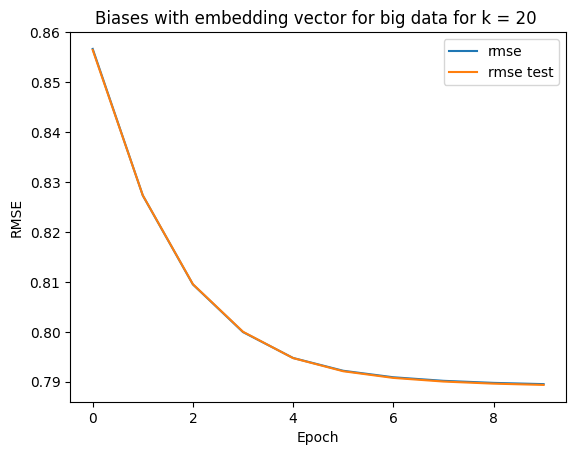

In [ ]:
#Plot of the last training loop for the rmses.
import matplotlib.pyplot as plt
plt.plot(liste_rmse,label='rmse')
plt.plot(test_rmse, label = 'rmse test')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Biases with embedding vector for big data for k = 20 ')
plt.savefig('rmse.pract.all.pdf', format = 'pdf', bbox_inches = 'tight')
plt.legend()

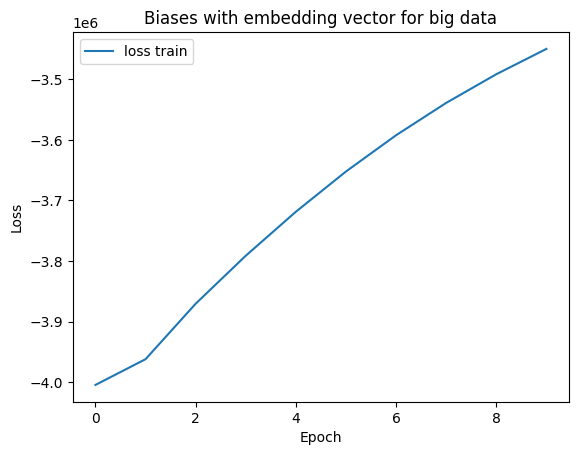

In [ ]:
#Plot of the loss function for the last training loop for the train data.
import matplotlib.pyplot as plt
plt.plot(liste_lost,label='loss train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biases with embedding vector for big data')
plt.legend()

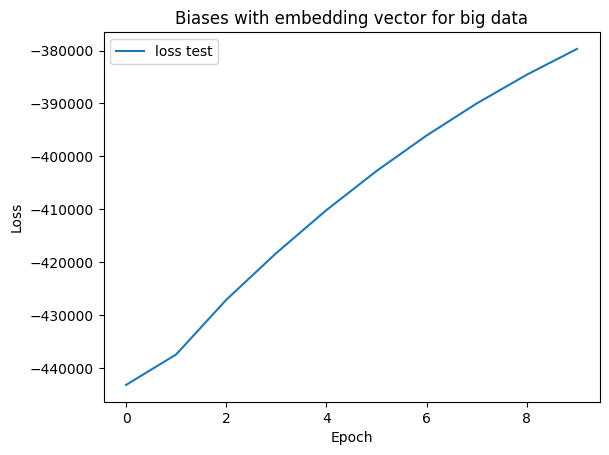

In [ ]:
#Plot of the loss function for the last training loop.
import matplotlib.pyplot as plt
plt.plot(test_loss,label='loss test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biases with embedding vector for big data')
plt.legend()

In [ ]:
#Training loop with a latent dimension equal to 2 to represent the embedding vector.
k = 2
user_len = len(data_by_user)
mov_len = len(data_by_movie)
user_biases_2d=np.zeros(user_len)
item_biases_2d=np.zeros(mov_len)
p=1/np.sqrt(k)
user_matrix_2d = np.random.normal(0,p, (user_len,k))
movie_matrix_2d = np.random.normal(0,p, (mov_len,k))
lamda = 0.2
gamma = 0.1
tau = 0.2
liste_lost = []
liste_rmse=[]
test_rmse = []
test_loss = []
epoch = 10
for j in range(epoch):
  for i in range(len(data_by_user)):
    user_vector = user_matrix_2d[i,:]
    bias = 0
    item_counter = 0
    for (n,r) in data_by_user[i]:
      movie_vector = movie_matrix_2d[n,:]
      bias += lamda* (r - item_biases_2d[n] - np.dot(user_vector, movie_vector))
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    user_biases_2d[i] = bias

  for i in range(len(data_by_user)):
    sum_vn = np.zeros((k,k))
    sum_r_vn = np.zeros(k)
    for (n,r) in data_by_user[i]:
      vn = movie_matrix_2d[n,:]
      sum_vn += np.outer(vn,vn)
      sum_r_vn += lamda*(r - user_biases_2d[i] - item_biases_2d[n])*vn
    sum_vn = lamda*(sum_vn) + tau*np.eye(k)
    user_matrix_2d[i,:] = np.linalg.solve(sum_vn, sum_r_vn)


  for n in range(len(data_by_movie)):
    movie_vector = movie_matrix_2d[n,:]
    bias = 0
    item_counter = 0
    for (i,r) in data_by_movie[n]:
      user_vector = user_matrix_2d[i,:]
      bias += lamda* (r - user_biases_2d[i] - np.dot(user_vector, movie_vector))
      item_counter += 1
    bias = bias / (lamda*item_counter + gamma)
    item_biases_2d[n]= bias

  for n in range(len(data_by_movie)):
    sum_um = np.zeros((k,k))
    sum_r_um = np.zeros(k)
    for (m,r) in data_by_movie[n]:
      um = user_matrix_2d[m,:]
      sum_um += np.outer(um,um)
      sum_r_um += lamda*(r - user_biases_2d[m] - item_biases_2d[n])*um
    sum_um = lamda*(sum_um) + tau*np.eye(k)
    movie_matrix_2d[n,:] = np.linalg.solve(sum_um, sum_r_um)

  rmse = 0
  a = 0
  for i in range(len(train_data_user)):
    a += len(train_data_user[i])
    user_vector = user_matrix_2d[i,:]
    for (n,r) in (train_data_user[i]):
      movie_vector = movie_matrix_2d[n,:]
      rmse += (r - (user_biases_2d[i]+ item_biases_2d[n]+np.dot(user_vector,movie_vector)))**2
  rmse = np.sqrt((1/a)*(rmse))
  liste_rmse.append(rmse)

  rmse_test = 0
  a = 0
  for i in range(len(test_data_user)):
    a += len(test_data_user[i])
    user_vector = user_matrix_2d[i,:]
    for (n,r) in (test_data_user[i]):
      movie_vector = movie_matrix_2d[n,:]
      rmse_test += (r - (user_biases_2d[i]+ item_biases_2d[n] + np.dot(movie_vector, user_vector)))**2
  rmse_test = np.sqrt((1/a)*(rmse_test))
  test_rmse.append(rmse_test)

  loss = 0
  for i in range (len(train_data_user)):
    us_b = user_biases_2d[i]
    user_vector = user_matrix_2d[i,:]
    for (n,r) in (train_data_user[i]):
      mv_b = item_biases_2d[n]
      movie_vector = movie_matrix_2d[n,:]
      loss += -(lamda / 2)*(r - (user_biases_2d[i]+ item_biases_2d[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  liste_lost.append(loss)

  loss_test = 0
  for i in range(len(test_data_user)):
    us_b = user_biases_2d[i]
    user_vector = user_matrix_2d[i,:]
    for (n,r) in test_data_user[i]:
      movie_vector = movie_matrix_2d[n,:]
      loss_test += -(lamda / 2)*(r - (user_biases[i]+ item_biases[n]))**2 -(gamma / 2)*(us_b)**2 - (gamma / 2)*(mv_b)**2 - (tau/2)*(np.dot(user_vector, user_vector)) - (tau/2)*(np.dot(movie_vector, movie_vector))
  test_loss.append(loss_test)

  if j < 10 or (j>10 and j % 10==0):
    print(f"loss:{loss},rmse train:{rmse}, loss test: {loss_test}, rmse test: {rmse_test}")



loss:-23549392.00016875,rmse train:0.8566758264469255, loss test: -2622971.805107051, rmse test: 0.8564752102975628
loss:-25146138.137629405,rmse train:0.8273223673448313, loss test: -2806460.3355163187, rmse test: 0.8273344181741853
loss:-25754015.729861673,rmse train:0.8094991719505232, loss test: -2868493.9902389804, rmse test: 0.8095431099471907
loss:-25943059.730067182,rmse train:0.7999504940026, loss test: -2884209.8923270055, rmse test: 0.8000188599226717
loss:-25952628.603372063,rmse train:0.794763880213239, loss test: -2881299.736470757, rmse test: 0.7947387067701639
loss:-25854015.76067116,rmse train:0.7922046266327253, loss test: -2867496.495129383, rmse test: 0.7921068657759837
loss:-25704062.621875294,rmse train:0.7909013755050956, loss test: -2848968.549440804, rmse test: 0.7907710209216072
loss:-25529359.58434312,rmse train:0.790189555990855, loss test: -2828351.9207974295, rmse test: 0.7900440781093093
loss:-25342662.11106167,rmse train:0.7897776814328943, loss test: -2

In [ ]:
#Function creating the embedding for some movies.
def embedding_vectors(data_points_idx_list, data, map_idx_to_movie, movie_matrix):
    labels = [] #stocking the name of the movies.
    vec1 = [] #stocking the first coordinate.
    vec2 = [] #stocking the second coordinate

    #Loop to take one by one the index of the movies in the list.
    for i in range(len(data_points_idx_list)):
        vector_movie = movie_matrix[data_points_idx_list[i], :]
        movie_id = map_idx_to_movie[data_points_idx_list[i]]
        title = data.loc[data['movieId'] == int(movie_id), 'title'].values[0]
        vec1.append(vector_movie[0])
        vec2.append(vector_movie[1])
        labels.append(title)

    #Plotting all vectors with labels.
    fig, ax = plt.subplots()
    ax.scatter(vec1, vec2)
    ax.axhline(0, color = 'black', linewidth = 1)
    ax.axvline(0, color = 'black', linewidth = 1)

    for j,label in enumerate(labels):
        ax.text(vec1[j], vec2[j], label)

    ax.grid(True)
    plt.savefig("embed.pdf", format = 'pdf', bbox_inches = 'tight')
    plt.show()





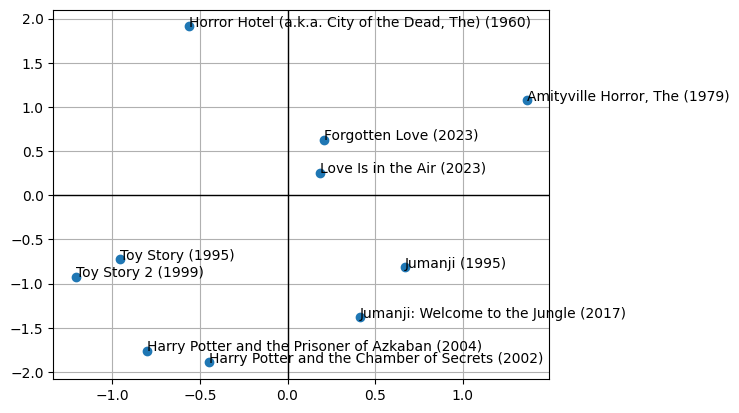

In [ ]:
#Making the embedding using the function built before.
import matplotlib.pyplot as plt
data_points_idx_list = [415, 628, 299, 20533, 191, 4174, 1287, 287, 53382, 44328]
embedding_vectors(data_points_idx_list, movie_data, map_idx_to_movie, movie_matrix_2d)